In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [282]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
!unzip /content/gdrive/MyDrive/archive.zip

Archive:  /content/gdrive/MyDrive/archive.zip
replace archive/s34/7.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

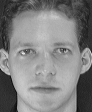

In [68]:
Image.open("archive/s1/1.pgm")


In [6]:
img = read_image('archive/s1/1.pgm')
img.shape

(112, 92)

In [7]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('archive/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [8]:
X, Y = get_data(size, total_sample_size)

In [9]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, input_shape=input_shape, data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [11]:
input_dim = x_train.shape[2:]
print(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

(1, 56, 46)


In [12]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [170]:
epochs = 13
rms = RMSprop()

model = Model([img_a, img_b], distance)

In [171]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [172]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, epochs=epochs)

Epoch 1/13
9/9 - 3s - loss: 0.0154 - val_loss: 0.0269
Epoch 2/13
9/9 - 0s - loss: 0.0123 - val_loss: 0.0263
Epoch 3/13
9/9 - 0s - loss: 0.0123 - val_loss: 0.0287
Epoch 4/13
9/9 - 0s - loss: 0.0123 - val_loss: 0.0267
Epoch 5/13
9/9 - 0s - loss: 0.0126 - val_loss: 0.0277
Epoch 6/13
9/9 - 0s - loss: 0.0128 - val_loss: 0.0266
Epoch 7/13
9/9 - 0s - loss: 0.0124 - val_loss: 0.0273
Epoch 8/13
9/9 - 0s - loss: 0.0116 - val_loss: 0.0282
Epoch 9/13
9/9 - 0s - loss: 0.0119 - val_loss: 0.0292
Epoch 10/13
9/9 - 0s - loss: 0.0119 - val_loss: 0.0254
Epoch 11/13
9/9 - 0s - loss: 0.0119 - val_loss: 0.0268
Epoch 12/13
9/9 - 0s - loss: 0.0111 - val_loss: 0.0280
Epoch 13/13
9/9 - 0s - loss: 0.0113 - val_loss: 0.0266


In [173]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [17]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [174]:
compute_accuracy(pred, y_test)

0.9566929133858267

In [ ]:
#сохранение модели
#model.save('path/to/location')

#загрузка модели
#model = load_model(model_filename)

In [150]:
#добавить фото человека в датасет компании, exists = N если такой человек уже в датасете есть в папке sN
import os
import json

def add_photo(photo_name, exists = 0, name = None):
  if exists == 0:
    path, dirs, files = next(os.walk("archive"))
    dirs_count = len(dirs)
    dirs_count += 1
    path = os.path.join("archive/s" + str(dirs_count))
    os.mkdir(path)
    #добавить имя в json имен
    with open("archive/names.json") as f:
      data = json.load(f)
      data[str(dirs_count)] = name
      file = open("archive/names.json", "w")
      file.write(data)
      file.close()
  else:
    path = os.path.join("archive/s" + str(exists))
  
  path1, dirs, files = next(os.walk(path))
  n = len(files) + 1
  os.rename(os.path.join(photo_name), os.path.join(path + "/" + str(n) + '.pgm')) #перемещение фото в папку человека с порядковым номером

In [20]:
!unzip /content/gdrive/MyDrive/processed_images.zip

Archive:  /content/gdrive/MyDrive/processed_images.zip
replace processed_images/8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: processed_images/8.jpg  
replace processed_images/9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: processed_images/9.jpg  
replace processed_images/14.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: processed_images/14.jpg  
replace processed_images/15.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: processed_images/15.jpg  
replace processed_images/12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: processed_images/12.jpg  
replace processed_images/13.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: processed_images/13.jpg  
  inflating: processed_images/11.jpg  
  inflating: processed_images/10.jpg  
  inflating: processed_images/4.jpg  
  inflating: processed_images/5.jpg  
  inflating: processed_images/7.jpg  
  inflating: processed_images/6.jpg  
  inflating: processed_images/2.jpg  
  inflati

In [22]:
add_photo("processed_images/11.jpg", exists = 0)

for i in range(9):
  add_photo("processed_images/"+str(i)+".jpg", 41)

In [52]:
!ls archive/s41

10.pgm	1.pgm  2.pgm  3.pgm  4.pgm  5.pgm  6.pgm  7.pgm  8.pgm	9.pgm


In [93]:
def resize_all(number): #сжать все фото в папке под номером number 
  path, dirs, files = next(os.walk('archive/s' + str(number)))
  for file_ in files:
    image = Image.open('archive/s' + str(number) + "/" + file_)
    new_image = image.resize((92, 112))
    new_image.save('archive/s' + str(number) + "/" + file_)


resize_all(41)

In [100]:
#дообучение нейронки на нового человека

#генерация пар с этим человеком для дообучения
def get_pairs(number, size, total_sample_size): #number - номер папки человека
  path, dirs, files = next(os.walk("archive"))
  dirs_count = len(dirs)

  #path, dirs1, files = next(os.walk('archive/s' + str(number)))
  image_p = Image.open('archive/s' + str(number) + '/' + str(1) + '.pgm')
  image = np.array(image_p)
  #reduce the size
  image = image[::size, ::size]
  #get the new size
  dim1 = image.shape[0]
  dim2 = image.shape[1]
  
  count = 0
    
  #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
  x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
  y_genuine = np.zeros([total_sample_size, 1])

  for i in range(len(dirs)):
        for j in range(int(total_sample_size/len(dirs))):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

  count = 0
  x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
  y_imposite = np.zeros([total_sample_size, 1])
  
  for i in range(int(total_sample_size/10)):
      for j in range(10):
          
          #read images from different directory (imposite pair)
          while True:
              ind1 = np.random.randint(len(dirs))
              ind2 = np.random.randint(len(dirs))
              if ind1 != ind2:
                  break
                  
          img1 = read_image('archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
          img2 = read_image('archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

          img1 = img1[::size, ::size]
          img2 = img2[::size, ::size]

          x_imposite_pair[count, 0, 0, :, :] = img1
          x_imposite_pair[count, 1, 0, :, :] = img2
          #as we are drawing images from the different directory we assign label as 0. (imposite pair)
          y_imposite[count] = 0
          count += 1
          
  #now, concatenate, genuine pairs and imposite pair to get the whole data
  X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
  Y = np.concatenate([y_genuine, y_imposite], axis=0)

  return X, Y

In [175]:
X, Y = get_pairs(41, 2, 1000)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, epochs=30)

Epoch 1/30
9/9 - 0s - loss: 0.0209 - val_loss: 0.0283
Epoch 2/30
9/9 - 0s - loss: 0.0176 - val_loss: 0.0238
Epoch 3/30
9/9 - 0s - loss: 0.0169 - val_loss: 0.0255
Epoch 4/30
9/9 - 0s - loss: 0.0152 - val_loss: 0.0283
Epoch 5/30
9/9 - 0s - loss: 0.0169 - val_loss: 0.0250
Epoch 6/30
9/9 - 0s - loss: 0.0153 - val_loss: 0.0262
Epoch 7/30
9/9 - 0s - loss: 0.0145 - val_loss: 0.0230
Epoch 8/30
9/9 - 0s - loss: 0.0143 - val_loss: 0.0221
Epoch 9/30
9/9 - 0s - loss: 0.0140 - val_loss: 0.0236
Epoch 10/30
9/9 - 0s - loss: 0.0141 - val_loss: 0.0236
Epoch 11/30
9/9 - 0s - loss: 0.0142 - val_loss: 0.0238
Epoch 12/30
9/9 - 0s - loss: 0.0128 - val_loss: 0.0253
Epoch 13/30
9/9 - 0s - loss: 0.0126 - val_loss: 0.0224
Epoch 14/30
9/9 - 0s - loss: 0.0126 - val_loss: 0.0231
Epoch 15/30
9/9 - 0s - loss: 0.0126 - val_loss: 0.0242
Epoch 16/30
9/9 - 0s - loss: 0.0128 - val_loss: 0.0265
Epoch 17/30
9/9 - 0s - loss: 0.0115 - val_loss: 0.0310
Epoch 18/30
9/9 - 0s - loss: 0.0121 - val_loss: 0.0260
Epoch 19/30
9/9 - 0

In [176]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])
compute_accuracy(pred, y_test)

0.9404761904761905

In [255]:
def pairs_for_one_image(path_to_photo):
  path, dirs, files = next(os.walk("archive"))
  dirs_count = len(dirs)

  image = Image.open(path_to_photo)
  image = np.array(image.resize((92, 112)))
  image = image[::size, ::size]
  #get the new size
  dim1 = image.shape[0]
  dim2 = image.shape[1]

  x_pair = np.zeros([dirs_count, 2, 1, dim1, dim2]) #по одной паре с каждым человеком
  for i in range(len(dirs)):
    img_p = read_image('archive/s' + str(i+1) + '/' + str(np.random.randint(9) + 1) + '.pgm', 'rw+')
    img_p = img_p[::size, ::size]
    x_pair[i, 0, 0, :, :] = image
    x_pair[i, 1, 0, :, :] = img_p
  return x_pair/255

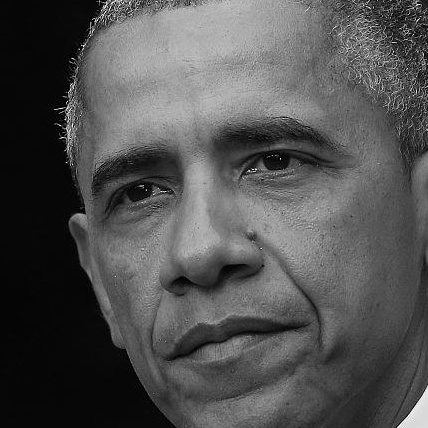

In [138]:
Image.open("processed_images/12.jpg")

In [285]:
#создам json файл для имен по id (это можно сделать заранее и положить отдельно в архив)
import json

annotations = json.dumps({'1' : 'Al', '2' : 'Bl', '3' : 'Cl', '4' : 'Zl', '5' : 'Dan','6' : 'Dan','7' : 'Dan', '8' : 'Dan','9' : 'Dan','10' : 'Dan',
                          '11' : 'Dan', '12' : 'Dan', '13' : 'Dan', '14' : 'Dan', '15' : 'Dan', '16' : 'Dan', '17' : 'Dan', '18' : 'Dan','19' : 'Dan',
                          '20' : 'Dan', '21' : 'Dan', '22' : 'Dan', '23' : 'Dan', '24' : 'Dan', '25' : 'Dan', '26' : 'Dan', '27' : 'Dan', '28' : 'Dan','29' : 'Dan',
                          '30' : 'Dan', '31' : 'Dan', '32' : 'Dan', '33' : 'Dan', '34' : 'Dan', '35' : 'Dan', '36' : 'Dan', '37' : 'Dan', '38' : 'Dan', '39' : 'Dan', '40' : 'Dan',
                          '41' : 'Barak Obama'})
file = open("archive/names.json", "w")
file.write(annotations)
file.close()

with open("archive/names.json") as f:
    data = json.load(f)
    print(data['41'])

Barak Obama


In [187]:
def predict_one_image(path_to_photo):
  x_final_test = pairs_for_one_image(path_to_photo)
  final_pred = model.predict([x_final_test[:, 0], x_final_test[:, 1]])
  #final_pred
  best_match = final_pred.argmin() + 1
  if final_pred[best_match-1] < 0.5:
    with open("archive/names.json") as f:
      data = json.load(f)
      return data[str(best_match)]
  else:
    return "Undefined"

answer = predict_one_image("processed_images/12.jpg")
answer

'Barak Obama'

In [168]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2021-06-09 18:44:10--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-06-09 18:44:10 (133 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2021-06-09 18:44:11--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

In [179]:
#теперь свяжем детекцию и классификацию

import cv2

prototxt = 'deploy.prototxt'
model_cv = 'res10_300x300_ssd_iter_140000.caffemodel'
model_cv = cv2.dnn.readNetFromCaffe(prototxt, model_cv)

In [291]:
def check_photo(path_to_photo):
  image = cv2.imread(path_to_photo)

  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  model_cv.setInput(blob)
  detections = model_cv.forward()

  path, dirs, files = next(os.walk("frames"))
  os.mkdir("frames/z"+ str(len(dirs) + 1))

  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, save it as a separate file
    if (confidence > 0.5):
      frame = image[startY:endY, startX:endX]

      path, dirs1, files = next(os.walk("frames"))
      cv2.imwrite("frames/z"+ str(len(dirs) + 1)+ "/" +str(len(files) + 1) + ".jpg", frame)
      os.rename(os.path.join("frames/z"+ str(len(dirs) + 1)+ "/" +str(len(files) + 1) + ".jpg"), os.path.join("frames/z"+ str(len(dirs) + 1)+ "/" +str(len(files) + 1) + ".pgm"))
    
      #обработка всех выделенных лиц
  
      img = Image.open("frames/z"+ str(len(dirs) + 1)+ "/" +str(len(files) + 1) + ".pgm")
      img = ImageOps.grayscale(img) #перевести в чб
      img.save("frames/z"+ str(len(dirs) + 1)+ "/" +str(len(files) + 1) + ".pgm")
      pr = predict_one_image("frames/z"+ str(len(dirs) + 1)+ "/" +str(len(files) + 1) + ".pgm")
      #print(pr)
      image = cv2.imread(path_to_photo)
      cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)
      cv2.putText(image, pr, (startX, startY+20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
      cv2.imwrite(path_to_photo, image)

In [292]:
!rm -rf frames/

Barak Obama
Dan


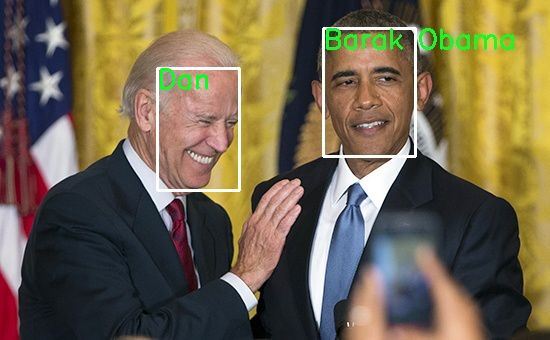

In [293]:
os.mkdir("frames")
#predict_one_image("frames/z1/1.pgm")
from PIL import Image, ImageOps

check_photo("/content/gdrive/MyDrive/presidents.jpg")
Image.open("/content/gdrive/MyDrive/presidents.jpg")
